In [1]:
import json
import numpy as np
from math import log
import pandas as pd

# Load configuration
with open("../../config/config_notebooks_TNBC_with_HER2_model.json", "r") as config_file:
    config = json.load(config_file)


In [2]:
# Let's load one result to see
def normalized_cluster_entropy(counts: pd.Series, n_clusters: int) -> float:
    """Return entropy-based dispersion score in [0, 1] for cluster counts."""
    probs = counts.values / counts.values.sum()
    entropy = -np.sum(probs * np.log10(probs + 1e-12))
    max_entropy = log(n_clusters) if n_clusters > 1 else 1.0
    return float(entropy / max_entropy) if max_entropy > 0 else 0.0



In [4]:
import pandas as pd
import os 
import glob
# Check full models
patient_cluster_stats = []

for model_type, names, benchmark_path in zip([config['retrained_model_list2_type']],
                                             [config['retrained_model_list2']],
                                             [config['retrained_benchmark_folder2']]):
    invasive_path = os.path.join(benchmark_path, "invasive_cancer_clustering", "kmeans")                                          
    optimal_clusters = pd.read_csv(os.path.join(invasive_path, "optimal_clusters.csv"), index_col=0)

    for name in names:

        filename = glob.glob(os.path.join(invasive_path, name, f"invasive_labels_{optimal_clusters.loc[name, 'n_clusters']}_clusters_umap_min_dist*"))[0]
        df = pd.read_csv(filename, index_col=0)

        df["patient"] = df.index.str.split("_").str[0]
        df["type"] = ["spot" if "spot" in idx else "patch" for idx in df.index]
        patient_with_low_invasive_cancer = df.value_counts("patient")[df.value_counts("patient") < 100].index.tolist()
        df = df[~df["patient"].isin(patient_with_low_invasive_cancer)]
        df = df[df["type"] == "spot"]

        n_global_clusters = df["predicted_label"].nunique()
        if n_global_clusters == 0:
            raise ValueError("No predicted_label values found in the dataframe after filtering.")


        for patient, group in df.groupby("patient"):
            cluster_counts = group["predicted_label"].value_counts()
            cluster_prop = cluster_counts/cluster_counts.sum()
            cluster_prop_dict = {k: v for k, v in zip(cluster_prop.index, cluster_prop.values)}
            for i in range(n_global_clusters):
                if i not in cluster_prop_dict.keys():
                    cluster_prop_dict[i] = 0

            cluster_prop_dict = dict(sorted(cluster_prop_dict.items()))
            diversity_score = normalized_cluster_entropy(cluster_counts, n_global_clusters)
            patient_cluster_stats.append({
                "patient": patient,
                "cluster_diversity_score": diversity_score,
                "n_clusters_present": int(cluster_counts.size),
                "dominant_cluster": cluster_counts.idxmax(),
                "model": name,
                "proportions": cluster_prop_dict,
            })



In [5]:
cluster_repartition_df = pd.DataFrame(patient_cluster_stats).sort_values("cluster_diversity_score", ascending=False)
cluster_repartition_df

,patient,cluster_diversity_score,n_clusters_present,dominant_cluster,model,proportions
184,TNBC78,0.393697,6,2,HER2_uni_full_koleo_16384_prototypes,"{0: 0.10561797752808989, 1: 0.2044943820224719..."
160,TNBC49,0.382101,6,4,HER2_uni_full_koleo_16384_prototypes,"{0: 0.07954545454545454, 1: 0.0909090909090909..."
168,TNBC58,0.364949,7,4,HER2_uni_full_koleo_16384_prototypes,"{0: 0.18733509234828497, 1: 0.1292875989445910..."
158,TNBC46,0.364010,6,4,HER2_uni_full_koleo_16384_prototypes,"{0: 0.22181818181818183, 1: 0.1309090909090909..."
138,TNBC21,0.359839,6,2,HER2_uni_full_koleo_16384_prototypes,"{0: 0.18439716312056736, 1: 0.1773049645390071..."
...,...,...,...,...,...,...
64,TNBC91,0.020182,3,1,uni,"{0: 0, 1: 0.9877112135176651, 2: 0.00614439324..."
32,TNBC52,0.017151,3,0,uni,"{0: 0.9896238651102465, 1: 0, 2: 0.00259403372..."
56,TNBC81,0.016539,3,1,uni,"{0: 0.005836575875486381, 1: 0.990272373540856..."
13,TNBC3,0.013895,3,2,uni,"{0: 0, 1: 0.0031645569620253164, 2: 0.99208860..."


In [6]:
import sys
sys.path.append("../../")
from digitalhistopathology.notebooks_utils import sort_retrained_models

retrained_models = config['retrained_model_list1'] + config['retrained_model_list2']
sorted_retrained_models = sort_retrained_models(retrained_models)


In [7]:
# order models according to sorted_retrained_models, keep any extra models at the end
model_order = [m for m in sorted_retrained_models if m in cluster_repartition_df['model'].unique()]
extra_models = [m for m in cluster_repartition_df['model'].unique() if m not in model_order]
categories = model_order + extra_models

cluster_repartition_df['model'] = pd.Categorical(cluster_repartition_df['model'], categories=categories, ordered=True)
cluster_repartition_df = cluster_repartition_df.sort_values('model').reset_index(drop=True)

cluster_repartition_df

,patient,cluster_diversity_score,n_clusters_present,dominant_cluster,model,proportions
0,TNBC65,0.010674,3,1,uni,"{0: 0, 1: 0.9942196531791907, 2: 0.00289017341..."
1,TNBC68,0.161756,4,3,uni,"{0: 0.004739336492890996, 1: 0.199052132701421..."
2,TNBC78,0.296494,5,3,uni,"{0: 0.011976047904191617, 1: 0.149700598802395..."
3,TNBC56,0.298381,4,3,uni,"{0: 0.31666666666666665, 1: 0.05, 2: 0.1166666..."
4,TNBC88,0.159083,4,3,uni,"{0: 0.0836940836940837, 1: 0.01875901875901876..."
...,...,...,...,...,...,...
195,TNBC50,0.291051,6,5,HER2_uni_full_koleo_16384_prototypes,"{0: 0.011412268188302425, 1: 0.199714693295292..."
196,TNBC4,0.286558,5,1,HER2_uni_full_koleo_16384_prototypes,"{0: 0.02830188679245283, 1: 0.4339622641509434..."
197,TNBC22,0.286379,7,6,HER2_uni_full_koleo_16384_prototypes,"{0: 0.3630573248407643, 1: 0.02165605095541401..."
198,TNBC93,0.157901,7,0,HER2_uni_full_koleo_16384_prototypes,"{0: 0.8092672413793104, 1: 0.08405172413793104..."


/tmp/ipykernel_540857/4083879780.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=cluster_repartition_df, y="cluster_diversity_score", x='model', palette=config["retrained_color_palette"],


Text(0.5, 1.0, 'Shannon entropy of cluster distributions across patients')

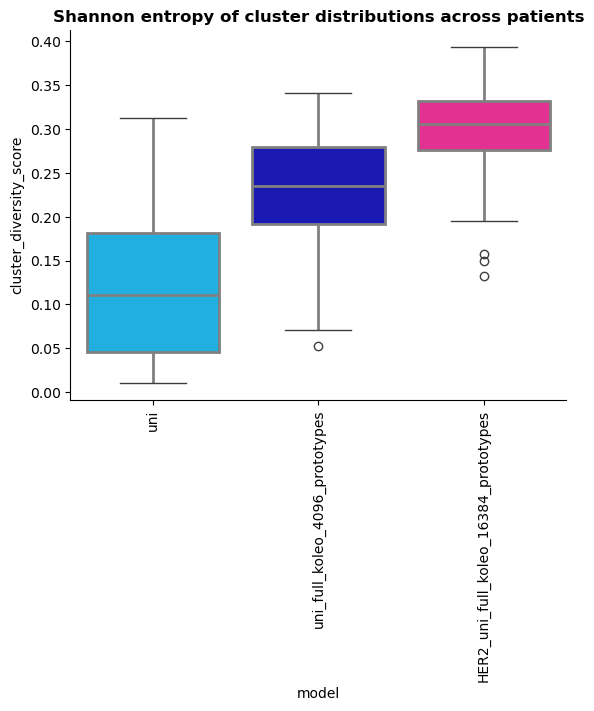

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(data=cluster_repartition_df, y="cluster_diversity_score", x='model', palette=config["retrained_color_palette"], 
            boxprops=dict(edgecolor='gray', linewidth=2), 
            medianprops=dict(color='gray', linewidth=2),
            whiskerprops=dict(color='gray', linewidth=2))
plt.xticks(rotation=90);
sns.despine()
plt.title("Shannon entropy of cluster distributions across patients", weight='bold')

In [60]:
## Hexagone simplex

In [9]:
palette={'0': '#31C4F3', '2': '#ACB5B6', '4': '#66BB46', '3': '#EC2A90', '1': '#F9A11B', '5': 'purple', '6': 'brown', 'not invasive': 'white'}


Model: uni
Number of patients: 69
Number of clusters: 5


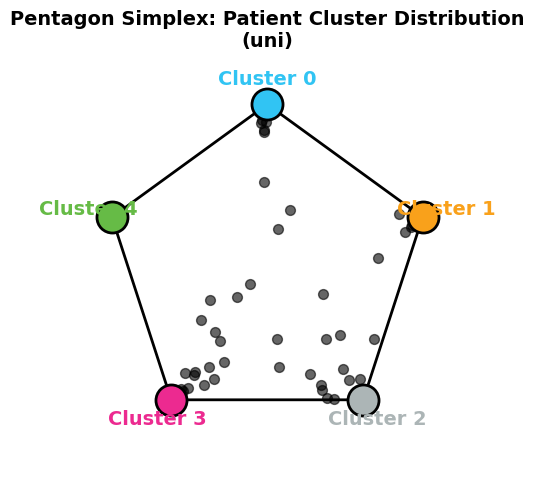

✓ Created simplex plot for uni

Model: uni_full_koleo_4096_prototypes
Number of patients: 62
Number of clusters: 6


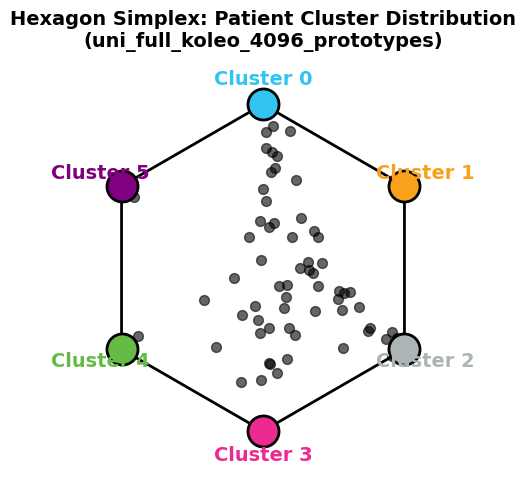

✓ Created simplex plot for uni_full_koleo_4096_prototypes

Model: HER2_uni_full_koleo_16384_prototypes
Number of patients: 69
Number of clusters: 7


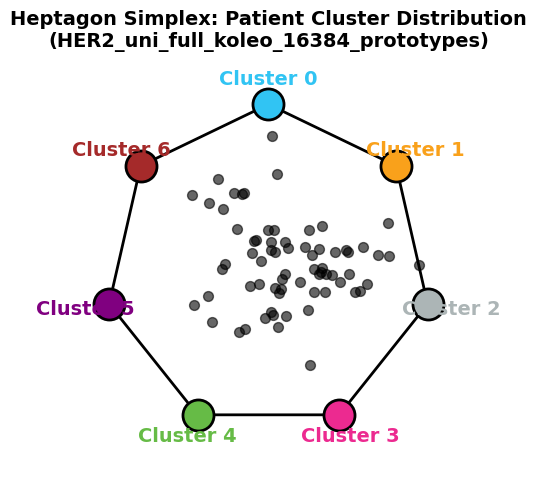

✓ Created simplex plot for HER2_uni_full_koleo_16384_prototypes


In [11]:
def create_simplex_plot(model_name, cluster_repartition_df, palette):
    """
    Create a simplex plot for a given model.
    Automatically adapts to the number of clusters (triangle, square, pentagon, hexagon, etc.)
    """
    # Filter for the specified model
    df_model = cluster_repartition_df[cluster_repartition_df['model'] == model_name].copy()
    
    if len(df_model) == 0:
        print(f"No data found for model: {model_name}")
        return None
    
    # Get number of clusters from the data
    n_clusters = len(df_model.iloc[0]['proportions'])
    n_patients = len(df_model)
    
    print(f"\nModel: {model_name}")
    print(f"Number of patients: {n_patients}")
    print(f"Number of clusters: {n_clusters}")
    
    # Define polygon vertices (n_clusters points equally spaced around a circle)
    # Start at top (90 degrees) and go clockwise
    angles = np.linspace(90, 90 - 360, n_clusters, endpoint=False) * np.pi / 180
    polygon_vertices = np.array([[np.cos(angle), np.sin(angle)] for angle in angles])
    
    # Convert cluster proportions to 2D coordinates using barycentric positioning
    patient_coords = []
    
    for _, row in df_model.iterrows():
        prop_dict = row['proportions']
        
        # Extract proportion weights for each cluster
        weights = np.array([prop_dict.get(i, 0.0) for i in range(n_clusters)])
        
        # Calculate weighted average of polygon vertices
        x = np.sum(weights * polygon_vertices[:, 0])
        y = np.sum(weights * polygon_vertices[:, 1])
        
        patient_coords.append({
            "patient": row["patient"],
            "x": x,
            "y": y,
            "dominant_cluster": row["dominant_cluster"],
            "cluster_diversity_score": row["cluster_diversity_score"]
        })
    
    df_coords = pd.DataFrame(patient_coords)
    
    # Create the simplex plot
    fig, ax = plt.subplots(figsize=(5, 5))
    
    # Draw polygon edges
    polygon_vertices_closed = np.vstack([polygon_vertices, polygon_vertices[0]])
    ax.plot(polygon_vertices_closed[:, 0], polygon_vertices_closed[:, 1], 
            'k-', linewidth=2, zorder=1)
    
    # Add cluster labels at vertices
    for i, vertex in enumerate(polygon_vertices):
        # Get color from palette, use default if not available
        vertex_color = palette.get(str(i), '#808080')
        
        ax.scatter(vertex[0], vertex[1], s=500, c=vertex_color, 
                  zorder=3, marker='o', edgecolors='black', linewidths=2)
        
        # Offset labels slightly outward
        offset = vertex * 1.15
        ax.text(offset[0], offset[1], f'Cluster {i}', 
                ha='center', va='center', fontsize=14, fontweight='bold', 
                zorder=4, color=vertex_color)
    
    # Plot patients as black points
    ax.scatter(df_coords['x'], df_coords['y'], 
               color='black',
               s=50, 
               alpha=0.6, 
               zorder=2)
    
    # Set equal aspect ratio and limits
    ax.set_aspect('equal')
    ax.set_xlim(-1.3, 1.3)
    ax.set_ylim(-1.3, 1.3)
    ax.set_xlabel('', fontsize=12)
    ax.set_ylabel('', fontsize=12)
    
    # Determine shape name for title
    shape_names = {2: "Line", 3: "Triangle", 4: "Square", 5: "Pentagon", 
                   6: "Hexagon", 7: "Heptagon", 8: "Octagon"}
    shape_name = shape_names.get(n_clusters, f"{n_clusters}-gon")
    
    ax.set_title(f'{shape_name} Simplex: Patient Cluster Distribution\n({model_name})', 
                 fontsize=14, fontweight='bold')
    ax.axis('off')
    
    sns.despine()
    plt.tight_layout()
    plt.show()
    
    return df_coords


# Create simplex plots for all models
all_coords = {}

for model_name in cluster_repartition_df['model'].unique():
    coords = create_simplex_plot(model_name, cluster_repartition_df, palette)
    if coords is not None:
        all_coords[model_name] = coords
        print(f"✓ Created simplex plot for {model_name}")